In [413]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; }</style>"))

%reset -f
# CARGAR LIBRERIAS
import sys, os

import numpy as np
import pandas as pd
from ipywidgets import interact_manual, Layout
import ipywidgets as widgets

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

widgets.interact_manual.opts['manual_name'] = "Run!"
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [414]:
# MODELO MATEMATICO

In [415]:
def rk4(init, h, fs, fun):
    sub_step: int = 4
    h_int = h / float(sub_step)
    for _ in list(range(sub_step)):
        k1 = fun(init, fs)
        k2 = fun(init + k1 / 2., fs)
        k3 = fun(init + k2 / 2., fs)
        k4 = fun(init + k3, fs)
        m = h_int * (k1 + 2 * k2 + 2 * k3 + k4) / 6.
        init = init + m
    return init


class Main:

    def __init__(self, init_year: int = 2016, end_year: int = 2020):
        self.init_year: int = init_year
        self.end_year: int = end_year

        self.dictionary()

    def __call__(self,
                 init_apas: float,
                 init_ganb: float,
                 init_acul: float,
                 init_pob: int,
                 init_stokpes: list):

        self.DF = self.principal_main(init_apas, init_ganb, init_acul, init_pob, init_stokpes)
        self.secundary_method()

    def secundary_method(self):
        tsacribov = self.dict['Tasa de sacrificio bovina']
        tprodcult = self.dict['Productividad de los cultivos']

        cop_tonalimento = self.dict['Precio promedio de una tonelada de alimento']
        cop_cab = self.dict['Precio promedio de una cabeza de ganado']
        cop_tonpesca = self.dict['Precio promedio de una tonelada de pescado']

        aut_alim = self.dict['Porcentaje de autoconsumo agricola']
        aut_gan = self.dict['Porcentaje de autoconsumo ganadero']
        aut_pes = self.dict['Porcentaje de autoconsumo pesquero']

        self.DF['Produccion agricola ton/ano'] = self.DF['Area de cultivos Ha'] * tprodcult
        self.DF['Sacrificio ganadera cab/ano'] = self.DF['Cabezas de ganado'] * tsacribov
        self.DF['Produccion pesquera ton/ano'] = self.DF['Pesca total']

        self.DF['Capital agricola COP/ano'] = self.DF['Produccion agricola ton/ano'] * cop_tonalimento * (1 - aut_alim)
        self.DF['Capital ganadero COP/ano'] = self.DF['Sacrificio ganadera cab/ano'] * cop_cab * (1 - aut_gan)
        self.DF['Capital pesquero COP/ano'] = self.fun_preciopesca(self.DF['Produccion pesquera ton/ano'], cop_tonpesca,
                                                                   aut_pes)

    def principal_main(self,
                       init_apas: float,
                       init_ganb: float,
                       init_acul: float,
                       init_pob: int,
                       init_stokpes: list):

        # CHARGE VALUES
        tcrecbov = self.dict['Tasa de cambio poblacional bovina']
        tsacribov = self.dict['Tasa de sacrificio bovina']
        tcambiopasto = self.dict['Tasa de cambio del area de pasto']

        tcambioculti = self.dict['Tasa de cambio del area de cultivo']

        t_stokp_anual = self.dict['Tasa de cambio del stock pesquero']

        tcrecimientopob = self.dict['Diferencia entre la tasa de natalidad y mortalidad poblacional']
        hab_gan = self.dict['Habitantes contratados por cada bovino']
        hab_hac = self.dict['Habitantes contratados por cada ha de cultivo']
        porc_hab_pes = self.dict['Porcentaje de la poblacion que son pescadores por falta de otro empleo']
        porc_hab_emigra = self.dict['Porcentaje de habitantes emigrantes anuales']
        mesa_veda = min(self.dict['Meses con periodos de veda'], 11.5)
        cab_ha_max = self.dict['Maximo numero de cabezas de ganado por ha']
        max_cul = self.dict['Maxima area de cultivos ha']
        efec_pesca = self.dict['Efecto sobre la captura de peces']
        cop_ton = np.array(self.dict['Precio promedio de una tonelada de pescado'])
        cop_tonalimento = self.dict['Precio promedio de una tonelada de alimento']
        tprodcult = self.dict['Productividad de los cultivos']
        cop_cab = self.dict['Precio promedio de una cabeza de ganado']
        tsacribov = self.dict['Tasa de sacrificio bovina']

        # BUILD LIST OF DATAFRAME
        apas_list: list[float] = [init_apas]
        ganb_list: list[int] = [init_ganb]
        acul_list: list[float] = [init_acul]
        pob_list: list[int] = [init_pob]

        pob_gan_list: list[float] = [np.nan]
        pob_cul_list: list[float] = [np.nan]
        pob_pes_list: list[float] = [np.nan]
        pob_des_list: list[float] = [np.nan]

        pesca_red_list: list[list] = [[np.nan]]
        pesca_ata_list: list[list] = [[np.nan]]
        pesca_chi_list: list[list] = [[np.nan]]
        pesca_nas_list: list[list] = [[np.nan]]
        pesca_list: list[list] = [[np.nan]]
        stokpes_ton_list: list[list] = [[np.nan]]

        year_list: list[float] = [self.init_year]
        migra_emigra = porc_hab_emigra * init_pob

        # RUN MODEL
        for year in np.arange(self.init_year + 1, self.end_year + 1):
            
            # PASTO
            apas: float = rk4(init=init_apas, h=1, fs=[tcambiopasto / 4.], fun=self.df_dt)
            apas = 0.0 if apas <= 0.0 else apas

            # GANADO
            ganb: int = int(rk4(init=init_ganb, h=1, fs=[tcrecbov / 4., tsacribov / 4., cab_ha_max*apas], fun=self.dg_dt))
            ganb = 0 if ganb <= 0 else ganb

            # CULTIVOS
            acul: float = rk4(init=init_acul, h=1, fs=[tcambioculti / 4., max_cul], fun=self.dc_dt)
            acul = 0. if acul <= 0. else acul
            acul = min(max_cul, acul)

            # POBLACION
            pob: int = int(rk4(init=init_pob, h=1, fs=[tcrecimientopob, migra_emigra], fun=self.df2_dt))
            pob = 0 if pob <= 0. else pob

            pob_gan: int = int(hab_gan * ganb)
            pob_gan = min(pob_gan, pob)

            pob_dispo: int = pob - pob_gan if pob >= pob_gan else 0

            pob_cul: int = int(hab_hac * acul)
            pob_cul = min(pob_dispo, pob_cul)
            pob_dispo = pob_dispo - pob_cul if pob_dispo >= pob_cul else 0

            pob_pes: int = int(pob * porc_hab_pes)
            pob_pes = min(pob_dispo, pob_pes)
            pob_dispo = pob_dispo - pob_pes if pob_dispo >= pob_pes else 0

            pob_desempleadad: int = pob_dispo

            # PESCA
            pesca_red = self.pesca_red(pob_pes, mesa_veda, efec_pesca[0])
            pesca_atarralla = self.pesca_ata(pob_pes, mesa_veda, efec_pesca[1])
            pesca_chinchorro = self.pesca_chin(pob_pes, mesa_veda, efec_pesca[2])
            pesca_nasas = self.pesca_nasa(pob_pes, mesa_veda, efec_pesca[3])
            
            cop_red = np.nansum(np.array(pesca_red) * cop_ton)
            cop_ata = np.nansum(np.array(pesca_atarralla) * cop_ton)
            cop_chi = np.nansum(np.array(pesca_chinchorro) * cop_ton)
            cop_nas = np.nansum(np.array(pesca_nasas) * cop_ton)
            
            cop_pes = (cop_red + cop_ata + cop_chi + cop_nas) / pob_pes
            cop_cul = acul * cop_tonalimento * tprodcult / pob_cul
            cop_gan = ganb * tsacribov * cop_cab / pob_gan
            
            
            porc_hab_pes_tmp = min(1.2 * (10**6 * cop_pes / \
                                          (max(cop_gan, 1) + max(cop_cul, 1))), 0.9)
            porc_hab_pes = (1/2) * (porc_hab_pes + porc_hab_pes_tmp)

            migraci = (1/3.) * (cop_pes + cop_cul + cop_gan) * 0.01697088609014997
            emigrac = (1/3.) * (cop_pes + cop_cul + cop_gan) * 0.01695261877625509
            
            migra_emigra = migraci - emigrac
            
            # STOCK PESQUERO
            pesca = list(np.array(pesca_red) +
                         np.array(pesca_atarralla) +
                         np.array(pesca_chinchorro) +
                         np.array(pesca_nasas))
            stokpes_ton: list = self.dspesque_dt(init=init_stokpes,
                                                 tasa=t_stokp_anual,
                                                 pesca=pesca)

            # UPDATE LIST OF VALUES
            apas_list.append(apas)
            ganb_list.append(ganb)
            acul_list.append(acul)
            pob_list.append(pob)

            pob_gan_list.append(pob_gan)
            pob_cul_list.append(pob_cul)
            pob_pes_list.append(pob_pes)
            pob_des_list.append(pob_desempleadad)

            stokpes_ton_list.append(stokpes_ton)
            pesca_list.append(pesca)

            pesca_red_list.append(pesca_red)
            pesca_ata_list.append(pesca_atarralla)
            pesca_chi_list.append(pesca_chinchorro)
            pesca_nas_list.append(pesca_nasas)

            year_list.append(year)

            # UPDATE INITIAL VALUES
            init_apas = apas
            init_ganb = ganb
            init_acul = acul
            init_pob = pob
            init_stokpes = stokpes_ton

        # ASIGNAR COLUMNAS AL DATAFRAME
        res = pd.DataFrame()
        res['Area de pasto Ha'] = apas_list
        res['Area de cultivos Ha'] = acul_list
        res['Cabezas de ganado'] = ganb_list

        res['Poblacion Hab'] = pob_list
        res['Poblacion ganadera Hab'] = pob_gan_list
        res['Poblacion agricultores Hab'] = pob_cul_list
        res['Poblacion pescadores Hab'] = pob_pes_list
        res['Poblacion desempleada Hab'] = pob_des_list

        res['Stock pesquero'] = stokpes_ton_list
        res['Pesca total'] = pesca_list

        res['Pesca con red'] = pesca_red_list
        res['Pesca con atarralla'] = pesca_ata_list
        res['Pesca con chinchorro'] = pesca_chi_list
        res['Pesca con nasas'] = pesca_nas_list

        res['year'] = year_list
        res.index = res['year']
        res.drop('year', axis=1, inplace=True)

        return res

    # MAIN METHODS (MODELOS)
    @staticmethod
    def pesca_nasa(pob, mesa_veda, f):
        # Caquetaia kraussii - Mojara amarillo
        # Cyphocharax magdalenae - Chango
        # Oreochromis niloticus - Mojarra Tilapía, cachama tilapia
        # Pimelodus yuma - Nicuro
        # Prochilodus magdalenae - Bocachico
        # Pseudoplatystoma magdaleniatum - Bagre rayado, bagre pintado
        # Triportheus magdalenae - Arenca

        m = np.array([0,
                      0,
                      0,
                      0.000856347,
                      0,
                      0,
                      0])

        b = np.array([0,
                      0,
                      0,
                      -107.1920763,
                      0,
                      0,
                      0])

        res = m * pob + b

        res[res <= 0] = 0
        return list(res * f * (12 - mesa_veda) / 12)

    @staticmethod
    def pesca_chin(pob, mesa_veda, f):
        # Caquetaia kraussii - Mojara amarilla
        # Cyphocharax magdalenae - Chango
        # Oreochromis niloticus - Mojarra Tilapía, cachama tilapia
        # Pimelodus yuma - Nicuro
        # Prochilodus magdalenae - Bocachico
        # Pseudoplatystoma magdaleniatum - Bagre rayado, bagre pintado
        # Triportheus magdalenae - Arenca

        m = np.array([-4.02551E-05,
                      -2.50199E-05,
                      7.23687E-05,
                      -6.57594E-05,
                      1.45605E-05,
                      4.17743E-06,
                      0])

        b = np.array([5.465467898,
                      3.402072028,
                      -9.029975254,
                      8.938496486,
                      -1.727143283,
                      -0.513135326,
                      0])

        res = m * pob + b
        res[res <= 0] = 0
        return list(res * f * (12 - mesa_veda) / 12.)

    @staticmethod
    def pesca_ata(pob, mesa_veda, f):
        # Caquetaia kraussii - Mojara amarilla
        # Cyphocharax magdalenae - Chango
        # Oreochromis niloticus - Mojarra Tilapía, cachama tilapia
        # Pimelodus yuma - Nicuro
        # Prochilodus magdalenae - Bocachico
        # Pseudoplatystoma magdaleniatum - Bagre rayado, bagre pintado
        # Triportheus magdalenae - Arenca

        m = np.array([0,
                      0,
                      -0.000372541,
                      0,
                      4.7351E-05,
                      0,
                      0])

        b = np.array([0,
                      0,
                      50.72136335,
                      0,
                      -6.303124414,
                      0,
                      0])

        res = m * pob + b
        res[res <= 0] = 0
        return list(res * f * (12 - mesa_veda) / 12.)

    @staticmethod
    def pesca_red(pob, mesa_veda, f):
        # Caquetaia kraussii - Mojara amarilla
        # Cyphocharax magdalenae - Chango
        # Oreochromis niloticus - Mojarra Tilapía, cachama tilapia
        # Pimelodus yuma - Nicuro
        # Prochilodus magdalenae - Bocachico
        # Pseudoplatystoma magdaleniatum - Bagre rayado, bagre pintado
        # Triportheus magdalenae - Arenca

        m = np.array([-2.8725E-05,
                      -0.000121769,
                      -4.0009E-06,
                      -0.000200983,
                      0.000110687,
                      7.24438E-06,
                      -0.000761314])

        b = np.array([3.910671685,
                      16.65814534,
                      0.543178611,
                      27.40229469,
                      -14.18989731,
                      -0.953955786,
                      105.2727617])

        res = m * pob + b
        res[res <= 0] = 0
        return list(res * f * (12 - mesa_veda) / 12.)

    @staticmethod
    def df_dt(init, fs):
        """METHOD CHANGE WITH ONE VALUE IN FS
        INIT: Valor inicial
        FS  : Fuente-sumidero : [Tasa de cambio]"""
        return init * fs[0]

    @staticmethod
    def df2_dt(init, fs):
        """METHOD CHANGE WITH TWO VALUE IN FS
        INIT: Valor inicial
        FS  : Fuente-sumidero : [Tasa de cambio]"""
        return init * fs[0] + fs[1]
    
    @staticmethod
    def dc_dt(init, fs):
        """METHOD CHANGE WITH TENDENCY VALUE
        INIT: Valor inicial
        FS  : Fuente-sumidero : [Tasa de cambio]"""
        c = init * fs[0] *(1 - init/fs[1])
        c = 0 if fs[1] == 0 else c
        return c
    
    @staticmethod
    def dg_dt(init, fs):
        """METHOD CHANGE WITH TENDENCY VALUE
        INIT: Valor inicial
        FS  : Fuente-sumidero : [Tasa de cambio]"""
        g = init * (fs[0] - fs[1])*(1 - init/fs[2])
        g = 0 if fs[2] == 0 else g
        return g

    def dspesque_dt(self, init: list, tasa: list, pesca: list):
        dspesque_dt = []
        for init_val, tasa_val, pesca_val in zip(init, tasa, pesca):
            tmp_value = rk4(init=init_val, h=1, fs=[tasa_val, -1*pesca_val], fun=self.df2_dt)
            tmp_value = 0. if tmp_value <= 0. else tmp_value
            dspesque_dt.append(tmp_value)
        return dspesque_dt

    @staticmethod
    def fun_preciopesca(pesca, precio, aut):
        res: list = []
        for ii in pesca.to_list():
            precio_sum: float = np.nansum(np.array(ii) * np.array(precio) * np.array(aut))
            res.append(precio_sum)
        return res

    # SECONDARY METHODS
    def dictionary(self):
        self.dict = {
            'Tasa de cambio poblacional bovina': 0.3602211382542184,
            'Tasa de sacrificio bovina': 0.036,
            'Tasa de cambio del area de pasto': -0.5918949122086804,

            'Tasa de cambio del area de cultivo': 1.1057243184576577,

            'Area de la cienaga la Zapatosa (km2)': 492.403913053385,

            'Habitantes contratados por cada bovino': 910_000/27_000_000,
            'Habitantes contratados por cada ha de cultivo': 0.01018781635734325,
            'Porcentaje de la poblacion que son pescadores por falta de otro empleo': 0.8492435271711207,

            'Tasa de cambio del stock pesquero': [0.0013753964080707587,
                                                  0.004227420167232215,
                                                  0.11055682239850029,
                                                  0.015814092043002326,
                                                  0.04362408217538664,
                                                  0.00029721046337343425,
                                                  0.00836754901190613],

            'Diferencia entre la tasa de natalidad y mortalidad poblacional': -0.001999999999999841,
            'Porcentaje de habitantes emigrantes anuales': 0.01490000169336295,

            'Productividad de los cultivos': 6.38,

            'Precio promedio de una tonelada de alimento': 2_177_136.22,
            'Precio promedio de una cabeza de ganado': 518_867.48,
            'Precio promedio de una tonelada de pescado': [0,
                                                           0,
                                                           0,
                                                           5_379_272.80,
                                                           5_048_579.80,
                                                           0,
                                                           0],

            'Porcentaje de autoconsumo agricola': 0.37620352128186463,
            'Porcentaje de autoconsumo ganadero': 0.08585747030620694,
            'Porcentaje de autoconsumo pesquero':[0.125,
                                                  0.000,
                                                  0.000,
                                                  0.125,
                                                  0.15125,
                                                  0.000,
                                                  0.000],
            'Meses con periodos de veda' : 0,
            'Maximo numero de cabezas de ganado por ha': 7,
            'Maxima area de cultivos ha': 643311.31019,
            'Efecto sobre la captura de peces':[1,
                                                1,
                                                1,
                                                1]
        }

    def example(self):
        """
        NA
        :return:
        VALORES RESULTADOS DEL MODELO CALIBRADO
        ---
        ESPECIES:
        ---
        Caquetaia kraussii - Mojara amarilla
        Cyphocharax magdalenae - Chango
        Oreochromis niloticus - Mojarra Tilapía, cachama tilapia
        Pimelodus yuma - Nicuro
        Prochilodus magdalenae - Bocachico
        Pseudoplatystoma magdaleniatum - Bagre rayado, bagre pintado
        Triportheus magdalenae - Arenca
        """
        init_apas: float = 46_761.910190
        init_ganb: int = 236_038
        init_pob: int = 175_175
        init_acul: float = 59_654.94271
        init_stokpes: list = [260.5772251,
                              171.9777471,
                              126.2344273,
                              72.58782199,
                              85.74912667,
                              614.5637949,
                              446.2158166]

        self(init_apas, init_ganb, init_acul, init_pob, init_stokpes)


## Modelo social Zapatosa

A continuación se presenta el modelo matematico que representa el modelo social de la cienaga Zapatosa en Colombia. Este se basa en el diagrama causal desarrollado para este fin. El cual se presenta a continuación.

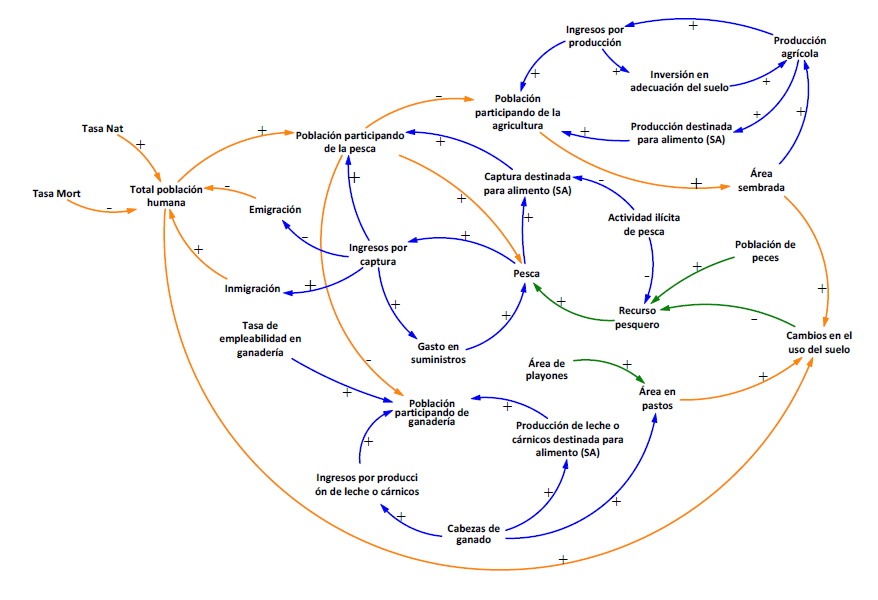


In [416]:
# PLOT FUNCTIONS
def plot(res1, res2):
    
    n_especies = len(res1['Stock pesquero'].iloc[-1])
    
    #'Poblacion Hab', 'Poblacion ganadera Hab', 'Poblacion agricultores Hab',
    #'Poblacion pescadores Hab', 'Poblacion desempleada Hab',
    
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Poblacion Hab'],
                            name='Poblacion Hab',
                            line=dict(color='#6D545D'),
                            legendgroup='group1'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Poblacion ganadera Hab'],
                            name='Poblacion ganadera Hab',
                            line=dict(color='#756D54'),
                            legendgroup='group2'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Poblacion agricultores Hab'],
                            name='Poblacion agricultores Hab',
                            line=dict(color='#8B9556'),
                            legendgroup='group3'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Poblacion pescadores Hab'],
                            name='Poblacion pescadores Hab',
                            line=dict(color='#ABB557'),
                            legendgroup='group4'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Poblacion desempleada Hab'],
                            name='Poblacion desempleada Hab',
                            line=dict(color='#BED558'),
                            legendgroup='group5'), 1, 1)


    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Poblacion Hab'],
                            name='Poblacion Hab',
                            legendgroup='group1',
                            line=dict(color='#6D545D'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Poblacion ganadera Hab'],
                            name='Poblacion ganadera Hab',
                            line=dict(color='#756D54'),
                            legendgroup='group2',
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Poblacion agricultores Hab'],
                            name='Poblacion agricultores Hab',
                            legendgroup='group3',
                            line=dict(color='#8B9556'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Poblacion pescadores Hab'],
                            name='Poblacion pescadores Hab',
                            line=dict(color='#ABB557'),
                            legendgroup='group4',
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Poblacion desempleada Hab'],
                            name='Poblacion desempleada Hab',
                            line=dict(color='#BED558'),
                            legendgroup='group5',
                            showlegend=False), 1, 2)


    fig.update_layout(title_text="Población")
    fig['layout']['yaxis']['title']='Hab'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    # 'Area de pasto Ha', 'Area de cultivos Ha'
    
    ################### AREAS
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Area de pasto Ha'],
                            name='Área de pastos',
                            line=dict(color='#6D545D'),
                            legendgroup='group1'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Area de cultivos Ha'],
                            name='Area de cultivos Ha',
                            line=dict(color='#756D54'),
                            legendgroup='group2'), 1, 1)


    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Area de pasto Ha'],
                            name='Área de pastos',
                            legendgroup='group1',
                            line=dict(color='#6D545D'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Area de cultivos Ha'],
                            name='Área de cultivos Ha',
                            line=dict(color='#756D54'),
                            legendgroup='group2',
                            showlegend=False), 1, 2)

    fig.update_layout(title_text="Área")
    fig['layout']['yaxis']['title']='Ha'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
     ################### SERVICIO ECOSISTEMICO
     # 'Produccion agricola ton/ano', 'Sacrificio ganadera cab/ano',
     # , 'Cabezas de ganado'
        
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Produccion agricola ton/ano'],
                            name='Produccion agricola ton/ano',
                            line=dict(color='#6D545D'),
                            legendgroup='group1'), 1, 1)


    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Produccion agricola ton/ano'],
                            name='Produccion agricola ton/ano',
                            legendgroup='group1',
                            line=dict(color='#6D545D'),
                            showlegend=False), 1, 2)

    fig.update_layout(title_text="Producción agrícola")
    fig['layout']['yaxis']['title']='ton/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Cabezas de ganado'],
                            name='Cabezas de ganado',
                            line=dict(color='#6D545D'),
                            legendgroup='group1'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Sacrificio ganadera cab/ano'],
                            name='Sacrificio ganadera cab/ano',
                            line=dict(color='#756D54'),
                            legendgroup='group2'), 1, 1)


    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Cabezas de ganado'],
                            name='Cabezas de ganado',
                            legendgroup='group1',
                            line=dict(color='#6D545D'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Sacrificio ganadera cab/ano'],
                            name='Sacrificio ganadera cab/ano',
                            line=dict(color='#756D54'),
                            legendgroup='group2',
                            showlegend=False), 1, 2)

    fig.update_layout(title_text="Pesca")
    fig['layout']['yaxis']['title']='cab'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    ###################### INGRESOS
    
    # 'Capital agricola COP/ano',
    # 'Capital ganadero COP/ano', 'Capital pesquero COP/ano'
    
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    # COL 1
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Capital agricola COP/ano'],
                            name='Capital agricola COP/ano',
                            line=dict(color='#6D545D'),
                            legendgroup='group1'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Capital ganadero COP/ano'],
                            name='Capital ganadero COP/ano',
                            line=dict(color='#756D54'),
                            legendgroup='group2'), 1, 1)
    fig.add_trace(go.Scatter(x = res1.index,
                             y = res1['Capital pesquero COP/ano'],
                            name='Capital pesquero COP/ano',
                            line=dict(color='#8B9556'),
                            legendgroup='group3'), 1, 1)

    # COL 2
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Capital agricola COP/ano'],
                            name='Capital agricola COP/ano',
                            legendgroup='group1',
                            line=dict(color='#6D545D'),
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Capital ganadero COP/ano'],
                            name='Capital ganadero COP/ano',
                            line=dict(color='#756D54'),
                            legendgroup='group2',
                            showlegend=False), 1, 2)
    fig.add_trace(go.Scatter(x = res2.index,
                             y = res2['Capital pesquero COP/ano'],
                            name='Capital pesquero COP/ano',
                            legendgroup='group3',
                            line=dict(color='#8B9556'),
                            showlegend=False), 1, 2)

    fig.update_layout(title_text="Capital")
    fig['layout']['yaxis']['title']='COP/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    ###########################
    colors = ['#C0C0C0', 
            '#808080', 
            '#800000', 
            '#808000',
            '#00FF00', 
            '#00FFFF', 
            '#008080', 
            '#000080', 
            '#FF00FF',
            '#800080', 
            '#CD5C5C', 
            '#F08080', 
            '#FA8072', 
            '#E9967A', 
            '#FFA07A', 
            '#FF7F50',
            '#FF6347',
            '#FF4500',
            '#FFD700',
            '#FFA500',
            '#FF8C00']
    ###########################

    ########################### STOCK PESQUERO
    # 'Pesca total', 'Pesca con red', 'Pesca con atarralla',
    # 'Pesca con chinchorro', 'Pesca con nasas',
    ###########################
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    for jj in range(n_especies):

        fig.add_trace(go.Scatter(x = res1.index,
                                 y = [res1['Stock pesquero'].iloc[ii][jj] for ii in range(1, len(res1))],
                                name='Stock pesquero - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj)), 1, 1)

        fig.add_trace(go.Scatter(x = res2.index,
                                 y = [res2['Stock pesquero'].iloc[ii][jj] for ii in range(1, len(res2))],
                                name='Stock pesquero - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj),
                                showlegend=False), 1, 2)

    fig.update_layout(title_text="Stock pesquero")
    fig['layout']['yaxis']['title']='TON'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    ###########################
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    for jj in range(n_especies):

        fig.add_trace(go.Scatter(x = res1.index,
                                 y = [res1['Pesca total'].iloc[ii][jj] for ii in range(1, len(res1))],
                                name='Pesca total - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj)), 1, 1)

        fig.add_trace(go.Scatter(x = res2.index,
                                 y = [res2['Pesca total'].iloc[ii][jj] for ii in range(1, len(res2))],
                                name='Pesca total - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj),
                                showlegend=False), 1, 2)

    fig.update_layout(title_text="Pesca")
    fig['layout']['yaxis']['title']='TON/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    ###########################
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    for jj in range(n_especies):

        fig.add_trace(go.Scatter(x = res1.index,
                                 y = [res1['Pesca con red'].iloc[ii][jj] for ii in range(1, len(res1))],
                                name='Pesca - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj)), 1, 1)

        fig.add_trace(go.Scatter(x = res2.index,
                                 y = [res2['Pesca con red'].iloc[ii][jj] for ii in range(1, len(res2))],
                                name='Pesca - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj),
                                showlegend=False), 1, 2)

    fig.update_layout(title_text="Pesca con red")
    fig['layout']['yaxis']['title']='TON/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    ###########################
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    for jj in range(n_especies):

        fig.add_trace(go.Scatter(x = res1.index,
                                 y = [res1['Pesca con atarralla'].iloc[ii][jj] for ii in range(1, len(res1))],
                                name='Pesca - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj)), 1, 1)

        fig.add_trace(go.Scatter(x = res2.index,
                                 y = [res2['Pesca con atarralla'].iloc[ii][jj] for ii in range(1, len(res2))],
                                name='Pesca - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj),
                                showlegend=False), 1, 2)

    fig.update_layout(title_text="Pesca con atarralla")
    fig['layout']['yaxis']['title']='TON/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    ###########################
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    for jj in range(n_especies):

        fig.add_trace(go.Scatter(x = res1.index,
                                 y = [res1['Pesca con chinchorro'].iloc[ii][jj] for ii in range(1, len(res1))],
                                name='Pesca - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj)), 1, 1)

        fig.add_trace(go.Scatter(x = res2.index,
                                 y = [res2['Pesca con chinchorro'].iloc[ii][jj] for ii in range(1, len(res2))],
                                name='Pesca - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj),
                                showlegend=False), 1, 2)

    fig.update_layout(title_text="Pesca con chinchorro")
    fig['layout']['yaxis']['title']='TON/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    
    ###########################
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                           subplot_titles=("Resultados simulados", "Resultados escenario"))

    for jj in range(n_especies):

        fig.add_trace(go.Scatter(x = res1.index,
                                 y = [res1['Pesca con nasas'].iloc[ii][jj] for ii in range(1, len(res1))],
                                name='Pesca - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj)), 1, 1)

        fig.add_trace(go.Scatter(x = res2.index,
                                 y = [res2['Pesca con nasas'].iloc[ii][jj] for ii in range(1, len(res2))],
                                name='Pesca - especie ' + str(jj),
                                line=dict(color=colors[jj]),
                                legendgroup='group'+str(jj),
                                showlegend=False), 1, 2)

    fig.update_layout(title_text="Pesca con nasas")
    fig['layout']['yaxis']['title']='TON/año'
    fig['layout']['xaxis']['title']='Año'
    fig['layout']['xaxis2']['title']='Año'

    fig.show()
    

In [417]:
#  RUN MAIN FUNCTION FOR BUILD GRAPH
def run(end_year, 
        ch1, ch2, ch3, 
        ch4_1, ch4_2, ch4_3, ch4_4,
        ch5):
    global res_1, res_2
    # Escenario sin cambios
    obj_1 = Main(end_year = end_year)
    obj_1.example()
    res_1 = obj_1.DF.copy()
    
    # Escenario con cambio
    obj_2 = Main(end_year = end_year)
    
    # PARAMETER CHANGE
    ch4 = [ch4_1, ch4_2, ch4_3, ch4_4]
    
    obj_2.dict['Tasa de cambio del area de cultivo'] = (1 + ch1/100) * obj_2.dict['Tasa de cambio del area de cultivo']
    obj_2.dict['Tasa de cambio poblacional bovina'] = (1 + ch2/100) * obj_2.dict['Tasa de cambio poblacional bovina']
    obj_2.dict['Meses con periodos de veda'] = ch3
    obj_2.dict['Tasa de cambio del area de pasto'] = (1 + ch5/100) * obj_2.dict['Tasa de cambio del area de pasto']
    obj_2.dict['Efecto sobre la captura de peces'] = list((1 + np.array(ch4)/100) * 
                                                          np.array(obj_2.dict['Efecto sobre la captura de peces']))
        
    # INITIAL VALUES
    init_apas: float = 46_761.910190
    init_ganb: int = 236_038
    init_pob: int = 175_175
    init_acul: float = 59_654.94271
    init_stokpes: list = [260.5772251,
                          171.9777471,
                          126.2344273,
                          72.58782199,
                          85.74912667,
                          614.5637949,
                          446.2158166]
    obj_2(init_apas, init_ganb, init_acul, init_pob, init_stokpes)
    res_2 = obj_2.DF.copy()
    
    plot(res_1, res_2)

In [418]:
# BUILD widgets
w_end_year = widgets.IntText(value=2050,
                       description='Año final de modelación:',
                       disabled=False, 
                       style={'description_width': 'initial'}, layout=Layout(width='90%'))
w_ch1 = widgets.IntSlider(description='Cambio en la tasa de cambio del cultivo: ',
                          value=0, min=-99.99, max=500, step=5,
                          style={'description_width': 'initial'}, layout=Layout(width='90%'))
w_ch2 = widgets.IntSlider(description=' Cambio en la tasa de cambio de la población bovina: ',
                          value=0, min=-99.99, max=500, step=5,
                          style={'description_width': 'initial'}, layout=Layout(width='90%'))
w_ch3 = widgets.IntSlider(description='Número de meses al año con restricción de pesca (veda): ',
                          value=0,
                          min=0,
                          max=12,
                          continuous_update=False,
                          orientation='horizontal',
                          readout=True,
                          readout_format='.0f',
                          style={'description_width': 'initial'}, layout=Layout(width='90%'))
w_ch41 = widgets.IntSlider(description='Cambio en la captura por el arte de pesca - red : ',
                           value=0, min=-100, max=500, step=5, 
                           style={'description_width': 'initial'}, layout=Layout(width='90%'))
w_ch42 = widgets.IntSlider(description='Cambio en la captura por el arte de pesca - atarralla : ',
                           value=0, min=-100, max=500, step=5,
                           style={'description_width': 'initial'}, layout=Layout(width='90%'))
w_ch43 = widgets.IntSlider(description='Cambio en la captura por el arte de pesca - Chinchorro : ',
                           value=0, min=-100, max=500, step=5,
                           style={'description_width': 'initial'}, layout=Layout(width='90%'))
w_ch44 = widgets.IntSlider(description='Cambio en la captura por el arte de pesca - Nasa : ',
                           value=0, min=-100, max=500, step=5,
                           style={'description_width': 'initial'}, layout=Layout(width='90%'))
w_ch5 = widgets.IntSlider(description='Cambio en la tasa de cambio del pasto: ',
                          value=0, min=-99.99, max=500, step=5,
                          style={'description_width': 'initial'}, layout=Layout(width='90%'))

Finalmente, se asignaran los parámetros y se generaran las gráficas asociadas al modelo.

In [419]:
interact_manual(run, end_year=w_end_year,ch1=w_ch1, ch2=w_ch2, ch3=w_ch3, 
        ch4_1=w_ch41, ch4_2=w_ch42, ch4_3=w_ch43, ch4_4=w_ch44, ch5=w_ch5)

interactive(children=(IntText(value=2050, description='Año final de modelación:', layout=Layout(width='90%'), …

<function __main__.run(end_year, ch1, ch2, ch3, ch4_1, ch4_2, ch4_3, ch4_4, ch5)>

In [421]:
#res_2.to_csv(r'D:\FNATURA\Escenarios\MS_CZapatosa_EscenarioSostenible.csv')